In [1]:
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
import math
import numpy as np

import vapor
from vapor.models import Cambium

2021-02-04 15:42:44,634 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
os.getcwd()

'/lustre/eaglefs/projects/vapor/vapor-open'

In [3]:
# --- Load Regional Best ---
results = pd.read_pickle(os.path.join('results','bnef_results_newtb.pkl'))
results['scenario'] = 'Mid Cost'
results['batt_size'] = 0
results.rename({'geometry':'point', 'region':'pca'}, axis='columns', inplace=True)

In [4]:
results.head()

,project_id,project_name,tech,structure,country,power_region,state,developer,offtaker,ppa_estimated_signing_year,...,cambium_co2_rate_avg_2043,cambium_portfolio_value_2043,cambium_busbar_energy_value_2044,cambium_co2_rate_lrmer_2044,cambium_grid_value_2044,cambium_capacity_value_2044,cambium_co2_rate_avg_2044,cambium_portfolio_value_2044,scenario,batt_size
2,607,Somerset Wind Farm,wind,Not reported,United States,PJM,Pennsylvania,Community Energy Inc,Carnegie Mellon University,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mid Cost,0
3,607,Somerset Wind Farm,wind,Not reported,United States,PJM,Pennsylvania,Community Energy Inc,Pennsylvania State University,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mid Cost,0
6,1502,Rail Splitter Wind Farm,wind,Virtual PPA,United States,MISO,Illinois,Horizon Wind Energy,University of Illinois at Urbana-Champaign,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mid Cost,0
10,2691,Spearville Wind Farm Phase I,wind,Virtual PPA,United States,SPP,Kansas,EDF Energy,Sprint Communications Inc,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mid Cost,0
23,4775,Notrees Wind Farm Phase I,wind,Physical PPA,United States,ERCOT,Texas,Tierra Energy LLC,NaN,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mid Cost,0


In [5]:
results.cambium_co2_rate_lrmer_2020.sum()

35522650.67445916

In [6]:
# --- Merge on Regions ---
region_map = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
region_map = region_map[['pca','rto','census_reg','inter']].drop_duplicates()

census_reg_dict = {
    'PA':'West',
    'MTN':'West',
    'ENC':'Midwest',
    'WNC':'Midwest',
    'WSC':'South',
    'MA':'Northeast',
    'NE':'Northeast',
    'ESC':'South',
    'SA':'South'
}
region_map['census_div'] = region_map['census_reg'].map(census_reg_dict)

df = results.merge(region_map, on='pca', how='left')


In [11]:
for i in df.columns:
    if 'gen' in i:
        print(i)

lifetime_gen_profile


In [12]:
years = [str(i) for i in range(2014,2051,1)]
cambium_cols = [i for i in df.columns if 'cambium' in i]
cambium_cols = [i for i in cambium_cols if i[-4:] in years]


# --- subset cambium columns ---
c_df = df[cambium_cols + list(region_map.columns) + ['project_id','tech','system_capacity']]

# --- melt ---
c_df = c_df.melt(id_vars= list(region_map.columns) +['project_id','tech','system_capacity'])
c_df['year'] = [int(i[-4:]) for i in c_df['variable']]
c_df['variable'] = [str(i[:-5]) for i in c_df['variable']]

c_df['value_mw'] = c_df['value'] / c_df['system_capacity'] * 1000


In [13]:
c_df.head()

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
0,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_busbar_energy_value,169.322663,2020,37.627258
1,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_busbar_energy_value,169.322663,2020,37.627258
2,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_busbar_energy_value,547.587008,2020,60.843001
3,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_busbar_energy_value,837.174914,2020,83.717491
4,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_busbar_energy_value,2276.277843,2020,25.069139


In [15]:
c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_lrmer') &\
         (c_df['year'] == 2020)\
        ].sort_values('value_mw', ascending=False)

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
6247,p37,rto11,WNC,eastern,Midwest,68792,wind,1600.0,cambium_co2_rate_lrmer,6.003806e+06,2020,3752.378605
6307,p53,rto8,WNC,eastern,Midwest,76655,wind,178000.0,cambium_co2_rate_lrmer,4.944923e+08,2020,2778.046373
6576,p53,rto8,WNC,eastern,Midwest,136337,wind,200000.0,cambium_co2_rate_lrmer,5.548558e+08,2020,2774.278909
6471,p53,rto8,WNC,eastern,Midwest,117962,wind,200000.0,cambium_co2_rate_lrmer,5.548558e+08,2020,2774.278909
6613,p53,rto8,WNC,eastern,Midwest,147503,wind,145000.0,cambium_co2_rate_lrmer,4.006199e+08,2020,2762.896198
...,...,...,...,...,...,...,...,...,...,...,...,...
6525,p61,rto10,WSC,texas,South,127155,pv,310000.0,cambium_co2_rate_lrmer,5.958724e+06,2020,19.221689
6822,p61,rto10,WSC,texas,South,10000123,pv,165000.0,cambium_co2_rate_lrmer,3.171576e+06,2020,19.221674
6823,p61,rto10,WSC,texas,South,10000124,pv,165000.0,cambium_co2_rate_lrmer,3.171576e+06,2020,19.221674
6703,p61,rto10,WSC,texas,South,199515,pv,318400.0,cambium_co2_rate_lrmer,6.120135e+06,2020,19.221531


In [16]:
c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_lrmer') &\
         (c_df['year'] == 2020)\
        ].sort_values('value_mw', ascending=False)['value'].sum()

35522650674.45915

In [18]:
(c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_lrmer') &\
         (c_df['year'] == 2020)\
        ].sort_values('value_mw', ascending=False)['system_capacity'].sum())/1000

36549.0

In [28]:

value_col = 'value'
grouped = c_df.groupby(['census_div','tech','year','variable'], as_index=False)[['system_capacity',value_col]].sum()
grouped['census_div'] = pd.Categorical(grouped['census_div'], categories=['Northeast','West','Midwest','South'], ordered=True)
grouped.sort_values('census_div', inplace=True)

grouped = grouped.loc[grouped['year'] == 2020]
grouped = grouped.loc[grouped['variable'].isin(['cambium_co2_rate_avg', 'cambium_co2_rate_lrmer','cambium_grid_value'])]
#grouped = grouped.loc[grouped['variable'].isin(['cambium_co2_rate_avg', 'cambium_grid_value'])]
grouped = grouped.loc[grouped['value'] > 0]

pivot = grouped.pivot_table(
    index=['census_div','tech'],
    columns='variable',
    values='value'
)
pivot.reset_index(inplace=True)

sc = grouped[['census_div', 'tech', 'system_capacity']].drop_duplicates()

pivot = pivot.merge(sc, on=['tech','census_div'])

# Assuming that original units for emissions are kg then the conversion to metric tons is ''=/ 1000'
# pivot['cambium_co2_rate_avg'] /= 2000
# pivot['cambium_co2_rate_lrmer'] /= 2000
pivot['cambium_co2_rate_avg'] /= 1000
pivot['cambium_co2_rate_lrmer'] /= 1000
pivot['cambium_grid_value']  /= 1e3
pivot['system_capacity'] /= 1000

#pivot.to_csv(os.path.join('images','existing_impacts_newtb.csv'))
pivot.sum()


tech                      pvwindpvwindpvwindpvwind
cambium_co2_rate_avg                       17990.8
cambium_co2_rate_lrmer                     35522.7
cambium_grid_value                         2322.27
system_capacity                              36549
dtype: object

In [29]:
pivot.census_div = pd.Categorical(pivot.census_div, 
                      categories=["South", "Midwest", "West", "Northeast"],
                      ordered=True)
# pivot[["system_capacity", "cambium_co2_rate_avg", "cambium_grid_value"]] = np.round(pivot[["system_capacity", "cambium_co2_rate_avg", "cambium_grid_value"]], decimals=0)
pivot['cambium_co2_rate_avg_mw'] = np.round(pivot['cambium_co2_rate_avg']/pivot['system_capacity'], decimals=2)
pivot['cambium_co2_rate_lrmer_mw'] = np.round(pivot['cambium_co2_rate_lrmer']/pivot['system_capacity'], decimals=2)
pivot['cambium_grid_value_mw'] = np.round(1E6*pivot['cambium_grid_value']/pivot['system_capacity'], decimals=0)
pivot[["system_capacity", "cambium_co2_rate_lrmer", "cambium_grid_value"]] = np.round(pivot[["system_capacity", "cambium_co2_rate_lrmer", "cambium_grid_value"]], decimals=0)
pivot.tech = pivot.tech.map({"pv": "Solar PV", "wind": "Wind"})
pivot = pivot[['census_div', "tech", "system_capacity", 
       "cambium_co2_rate_avg", "cambium_co2_rate_avg_mw",
       "cambium_co2_rate_lrmer", "cambium_co2_rate_lrmer_mw",
       "cambium_grid_value", "cambium_grid_value_mw"]].sort_values('census_div')
pivot.reset_index(inplace=True, drop=True)
pivot.to_csv(os.path.join('images','existing_impacts_newtb.csv'), index=False)

In [30]:
pivot

,census_div,tech,system_capacity,cambium_co2_rate_avg,cambium_co2_rate_avg_mw,cambium_co2_rate_lrmer,cambium_co2_rate_lrmer_mw,cambium_grid_value,cambium_grid_value_mw
0,South,Solar PV,11463.0,5149.458609,0.45,7207.0,0.63,757.0,65997.0
1,South,Wind,9974.0,3297.469303,0.33,8886.0,0.89,543.0,54474.0
2,Midwest,Solar PV,1032.0,771.103597,0.75,984.0,0.95,73.0,70423.0
3,Midwest,Wind,7072.0,5526.245222,0.78,12795.0,1.81,528.0,74688.0
4,West,Solar PV,4200.0,2357.272401,0.56,4260.0,1.01,262.0,62331.0
5,West,Wind,1174.0,382.269182,0.33,576.0,0.49,51.0,43669.0
6,Northeast,Solar PV,1424.0,425.533446,0.30,694.0,0.49,95.0,66551.0
7,Northeast,Wind,209.0,81.459692,0.39,120.0,0.58,14.0,65426.0


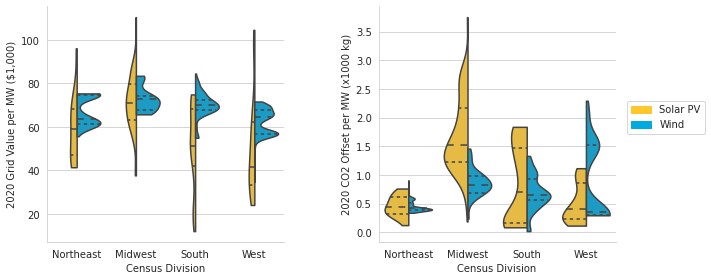

In [38]:
dist = c_df.copy()
# dist['census_div'] = pd.Categorical(dist['census_div'], categories=['Northeast','West','Midwest','South'], ordered=True)
# dist.sort_values('census_div', inplace=True)


sns.set_style('whitegrid')
#fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))
fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(10,4))

grid_value = dist.loc[(dist['variable'] == 'cambium_grid_value') & (dist['year'] == 2020)]
#co2_avg = dist.loc[(dist['variable'] == 'cambium_co2_rate_avg') & (dist['year'] == 2020)]
co2_lrmer = dist.loc[(dist['variable'] == 'cambium_co2_rate_lrmer') & (dist['year'] == 2020)]
co2_lrmer[['value', 'value_mw']] /= 1000
#grid_value = dist.loc[(dist['variable'] == 'cambium_grid_value')]
#co2_avg = dist.loc[(dist['variable'] == 'cambium_co2_rate_avg')]
#co2_lrmer = dist.loc[(dist['variable'] == 'cambium_co2_rate_lrmer')]

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

sns.violinplot(
    data=grid_value, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart',
    ax=ax1, cut=0, scale='area'
  )

#sns.violinplot(
#    data=co2_avg, x='census_div', y='value_mw',
#    hue='tech', split=True, inner='quart', 
#    ax=ax2, cut=0, scale='width'
#  )

sns.violinplot(
    data=co2_lrmer, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart', 
    ax=ax3, cut=0, scale='width'
  )

ax1.set_ylabel('2020 Grid Value per MW ($1,000)')
#ax2.set_ylabel('2020 Average CO2 Offset per MW (x1000 lbs)')
ax3.set_ylabel('2020 CO2 Offset per MW (x1000 kg)')
ax1.set_xlabel('Census Division')
#ax2.set_xlabel('Census Division')
ax3.set_xlabel('Census Division')

ax1.legend([],[], frameon=False)
#ax2.legend([],[], frameon=False)
ax3.legend([],[], frameon=False)

#ax2.set(ylim=(0, math.ceil(max(co2_lrmer.value_mw.max(),co2_avg.value_mw.max())/100)*100))
#ax3.set(ylim=(0, math.ceil(max(co2_lrmer.value_mw.max(),co2_avg.value_mw.max())/100)*100))

label_dict = {'pv':'Solar PV', 'wind':'Wind'}
custom_patches = [mpatches.Patch(color=vapor.tech_dict[k], label=v) for k,v in label_dict.items()]
plt.legend(handles=custom_patches, bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
sns.despine()

# g = sns.catplot(x='census_div', y='value_mw',
#                 hue='tech', col='variable',
#                data=dist, kind='violin', split=True, bw=.3,
#                height=5, aspect=1.2, sharey=False)


In [32]:
dist = c_df.copy()
dist.loc[(dist['variable'] == 'cambium_co2_rate_lrmer') & (dist['year'] == 2020)]

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
5850,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_lrmer,1980.815792,2020,440.181287
5851,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_lrmer,1980.815792,2020,440.181287
5852,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_co2_rate_lrmer,11007.715582,2020,1223.079509
5853,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_co2_rate_lrmer,26700.327464,2020,2670.032746
5854,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_co2_rate_lrmer,17298.062192,2020,190.507293
...,...,...,...,...,...,...,...,...,...,...,...,...
6820,p103,rto6,ENC,eastern,Midwest,10000118,pv,23500.0,cambium_co2_rate_lrmer,23208.959930,2020,987.615316
6821,p131,rto18,NE,eastern,Northeast,10000122,pv,54600.0,cambium_co2_rate_lrmer,22802.694682,2020,417.631771
6822,p61,rto10,WSC,texas,South,10000123,pv,165000.0,cambium_co2_rate_lrmer,3171.576177,2020,19.221674
6823,p61,rto10,WSC,texas,South,10000124,pv,165000.0,cambium_co2_rate_lrmer,3171.576177,2020,19.221674


<AxesSubplot:xlabel='ppa_estimated_last_year', ylabel='year'>

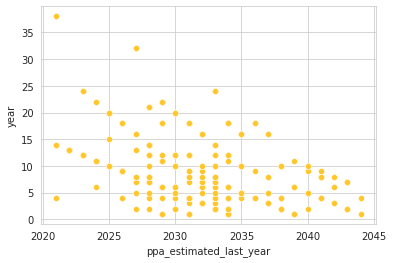

In [37]:
g_df = dist.loc[(dist['variable'] == 'cambium_co2_rate_lrmer') & 
                np.isnan(dist.value)].groupby('project_id', as_index=False)['year'].count()
#g_df.loc[g_df.year > 1]['project_id']
#g_df.head()
f_df = results[['ppa_estimated_last_year', 'project_id']]

g_df = g_df.merge(f_df, on='project_id').sort_values('year')
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(g_df)

sns.scatterplot(x='ppa_estimated_last_year', y='year', data=g_df)

In [33]:
bars.pivot_table(index='census_div', columns='tech', values='value').plot.bar(stacked=True)

NameError: name 'bars' is not defined

<AxesSubplot:xlabel='year', ylabel='value'>

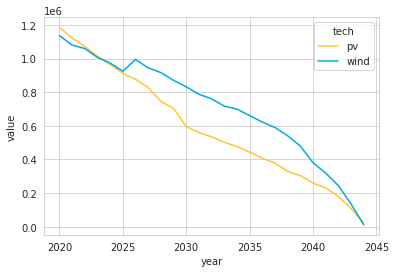

In [38]:
# --- plot ---
g_df = c_df.groupby(['year','variable','tech'], as_index=False)['value'].sum()
g_df = g_df.loc[g_df['variable'] == 'cambium_grid_value']
sns.lineplot(x='year', y='value', hue='tech', data=g_df)


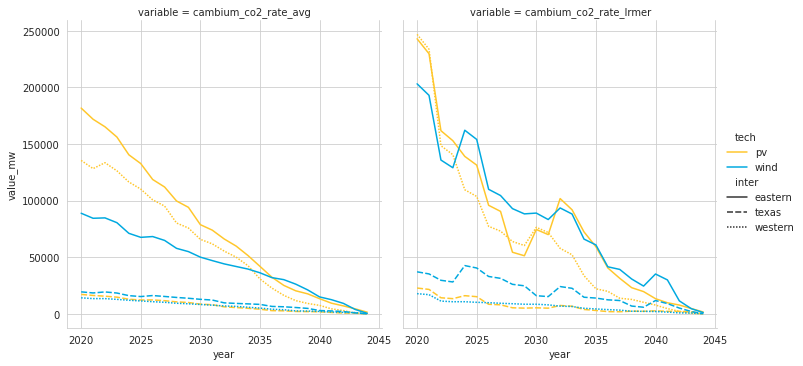

In [39]:
# --- plot ---
g_df = c_df.groupby(['year','variable','tech','inter'], as_index=False)['value_mw'].sum()
g_df = g_df.loc[g_df['variable'].isin(['cambium_co2_rate_avg', 'cambium_co2_rate_lrmer'])]
sns.relplot(x='year', y='value_mw', hue='tech', col="variable", data=g_df, style="inter", kind="line")


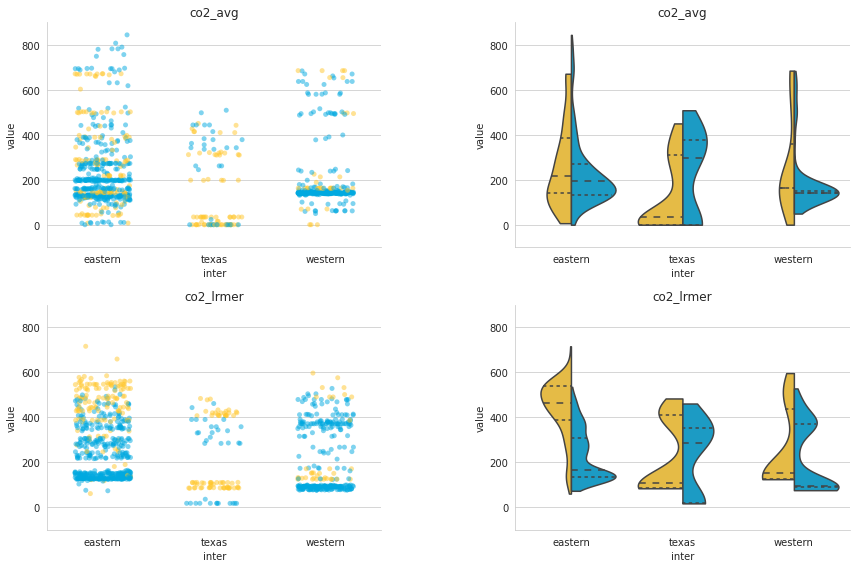

In [40]:
sns.set_style('whitegrid')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

df_sc_t = df[['tech', 'inter','lifetime_cambium_co2_rate_avg_mwh','lifetime_cambium_co2_rate_lrmer_mwh']]
df_sc_t = df_sc_t.melt(id_vars=['tech', 'inter'], var_name='variable')
df_sc_t.replace({'variable':{'lifetime_cambium_co2_rate_avg_mwh': 'co2_avg',
                                            'lifetime_cambium_co2_rate_lrmer_mwh': 'co2_lrmer'}}, inplace=True)

sns.stripplot(x='inter', y='value', hue='tech', data=df_sc_t.loc[df_sc_t.variable == "co2_avg"], 
              alpha=.5, ax=ax1, jitter=.25)
sns.violinplot(x='inter', y='value', hue='tech', data=df_sc_t.loc[df_sc_t.variable == "co2_avg"], 
               split=True, inner='quart', ax=ax2, cut=0)

sns.stripplot(x='inter', y='value', hue='tech', data=df_sc_t.loc[df_sc_t.variable == "co2_lrmer"], 
              alpha=.5, ax=ax3, jitter=.25)
sns.violinplot(x='inter', y='value', hue='tech', data=df_sc_t.loc[df_sc_t.variable == "co2_lrmer"], 
               split=True, inner='quart', ax=ax4, cut=0)

ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)
ax3.legend([],[], frameon=False)
ax4.legend([],[], frameon=False)

ax1.set_title('co2_avg')
ax2.set_title('co2_avg')
ax3.set_title('co2_lrmer')
ax4.set_title('co2_lrmer')

ax1.set(ylim=(-100, math.ceil(df_sc_t.value.max()/100)*100))
ax2.set(ylim=(-100, math.ceil(df_sc_t.value.max()/100)*100))
ax3.set(ylim=(-100, math.ceil(df_sc_t.value.max()/100)*100))
ax4.set(ylim=(-100, math.ceil(df_sc_t.value.max()/100)*100))

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
sns.despine()

In [96]:
c_df.head()

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
0,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_lrmer,1960.509202,2020,435.668712
1,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_lrmer,1960.509202,2020,435.668712
2,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_co2_rate_lrmer,7530.767646,2020,836.751961
3,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_co2_rate_lrmer,17541.414269,2020,1754.141427
4,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_co2_rate_lrmer,23465.233437,2020,258.427681


In [125]:
i_df = c_df.groupby(['tech', 'census_div', 'variable'], 
             as_index=False)['value'].apply(lambda x: np.std(x)/np.mean(x)).reset_index(drop=True)
i_df.loc[i_df.variable =="cambium_co2_rate_avg"].sort_values(['tech','variable', 'value'], 
                                                             ascending = [True,True, False])

,tech,census_div,variable,value
17,pv,West,cambium_co2_rate_avg,4.313808
2,pv,Midwest,cambium_co2_rate_avg,4.274984
7,pv,Northeast,cambium_co2_rate_avg,3.036932
12,pv,South,cambium_co2_rate_avg,3.026959
37,wind,West,cambium_co2_rate_avg,2.286982
27,wind,Northeast,cambium_co2_rate_avg,2.005327
32,wind,South,cambium_co2_rate_avg,1.407925
22,wind,Midwest,cambium_co2_rate_avg,1.275072


In [124]:
j_df = c_df.groupby(['tech', 'census_div', 'variable'], 
             as_index=False)['value'].apply(lambda x: np.var(x)).reset_index(drop=True)
j_df.loc[j_df.variable =="cambium_co2_rate_avg"].sort_values(['tech','variable', 'value'], 
                                                             ascending = [True,True, False])

,tech,census_div,variable,value
12,pv,South,cambium_co2_rate_avg,1.777102e+09
2,pv,Midwest,cambium_co2_rate_avg,1.285348e+09
17,pv,West,cambium_co2_rate_avg,6.785605e+08
7,pv,Northeast,cambium_co2_rate_avg,1.635376e+07
22,wind,Midwest,cambium_co2_rate_avg,2.770636e+09
32,wind,South,cambium_co2_rate_avg,7.985480e+08
37,wind,West,cambium_co2_rate_avg,2.863017e+08
27,wind,Northeast,cambium_co2_rate_avg,5.815486e+07


In [129]:
i_df = c_df.loc[c_df.year == 2020]
i_df = i_df.groupby(['tech', 'census_div', 'variable'], 
             as_index=False)['value'].apply(lambda x: np.std(x)/np.mean(x)).reset_index(drop=True)
i_df.loc[i_df.variable =="cambium_co2_rate_avg"].sort_values(['tech','variable', 'value'], 
                                                             ascending = [True,True, False])

<ipython-input-129-d14c4b7f778a>:3: RuntimeWarning: invalid value encountered in double_scalars
  as_index=False)['value'].apply(lambda x: np.std(x)/np.mean(x)).reset_index(drop=True)


,tech,census_div,variable,value
2,pv,Midwest,cambium_co2_rate_avg,4.198819
17,pv,West,cambium_co2_rate_avg,4.187500
7,pv,Northeast,cambium_co2_rate_avg,2.890590
12,pv,South,cambium_co2_rate_avg,2.489725
37,wind,West,cambium_co2_rate_avg,1.960077
27,wind,Northeast,cambium_co2_rate_avg,1.931001
32,wind,South,cambium_co2_rate_avg,1.209186
22,wind,Midwest,cambium_co2_rate_avg,1.131347


In [141]:
i_df = c_df.loc[(c_df.year == 2020) & (c_df.variable =="cambium_co2_rate_avg")]
i_df = i_df.groupby(['tech', 'census_div', 'variable'], 
             as_index=False)['value'].apply(lambda x: np.std(x)/np.mean(x)).reset_index(drop=True)
i_df.sort_values(['tech','variable', 'value'], 
                 ascending = [True,True, False])

,tech,census_div,variable,value
0,pv,Midwest,cambium_co2_rate_avg,4.198819
3,pv,West,cambium_co2_rate_avg,4.187500
1,pv,Northeast,cambium_co2_rate_avg,2.890590
2,pv,South,cambium_co2_rate_avg,2.489725
7,wind,West,cambium_co2_rate_avg,1.960077
5,wind,Northeast,cambium_co2_rate_avg,1.931001
6,wind,South,cambium_co2_rate_avg,1.209186
4,wind,Midwest,cambium_co2_rate_avg,1.131347


In [142]:
j_df = c_df.loc[(c_df.year == 2020) & (c_df.variable =="cambium_co2_rate_avg")]
j_df = j_df.groupby(['tech', 'census_div', 'variable'], 
             as_index=False)['value'].apply(lambda x: np.var(x)).reset_index(drop=True)
j_df.sort_values(['tech','variable', 'value'], 
                 ascending = [True,True, False])

,tech,census_div,variable,value
0,pv,Midwest,cambium_co2_rate_avg,4.123990e+09
2,pv,South,cambium_co2_rate_avg,3.610443e+09
3,pv,West,cambium_co2_rate_avg,9.390749e+08
1,pv,Northeast,cambium_co2_rate_avg,3.370856e+07
4,wind,Midwest,cambium_co2_rate_avg,4.141440e+09
6,wind,South,cambium_co2_rate_avg,1.364925e+09
7,wind,West,cambium_co2_rate_avg,3.799385e+08
5,wind,Northeast,cambium_co2_rate_avg,7.872296e+07


In [143]:
v_df = c_df.loc[(c_df.year == 2020) & (c_df.variable =="cambium_co2_rate_avg")]
v_df = v_df.groupby(['tech', 'census_div', 'variable'], 
             as_index=False)['value'].mean().reset_index(drop=True)
v_df.sort_values(['tech','variable', 'value'], 
                 ascending = [True,True, False])

,tech,census_div,variable,value
2,pv,South,cambium_co2_rate_avg,24133.972418
0,pv,Midwest,cambium_co2_rate_avg,15294.372237
3,pv,West,cambium_co2_rate_avg,7318.049315
1,pv,Northeast,cambium_co2_rate_avg,2008.554108
4,wind,Midwest,cambium_co2_rate_avg,56882.655188
6,wind,South,cambium_co2_rate_avg,30553.522529
7,wind,West,cambium_co2_rate_avg,9944.513783
5,wind,Northeast,cambium_co2_rate_avg,4594.817438
